In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [11]:
# Try to use xgboost! haha
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

In [12]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

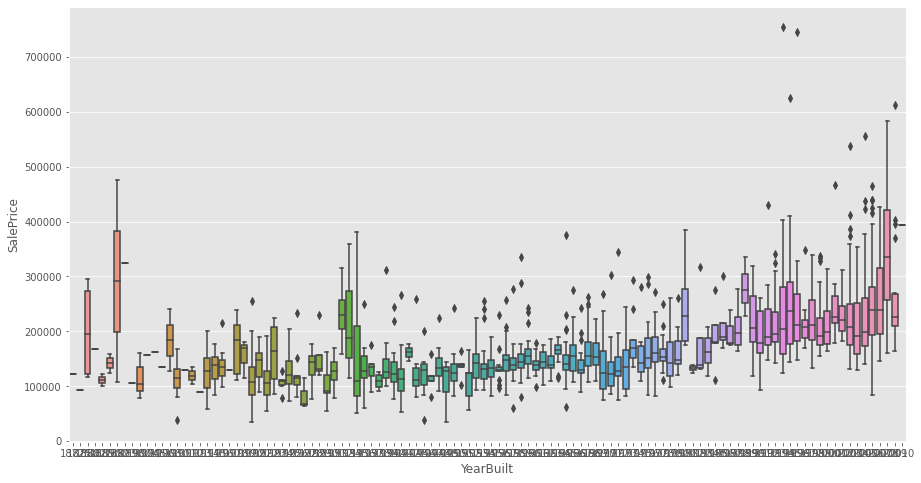

In [13]:

plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

(0.0, 800000.0)

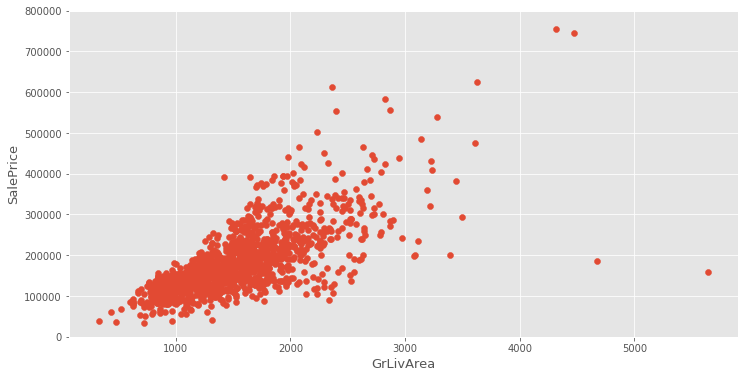

In [14]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [15]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [16]:
full=pd.concat([train,test], ignore_index=True)

In [17]:
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2917, 80)

In [19]:
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

In [20]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [21]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)

In [22]:
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [23]:
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [24]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [25]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [26]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [27]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [28]:

NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [29]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [30]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [31]:
map_values()


'Done!'

In [32]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

In [33]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [34]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [35]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [36]:
full2 = full.copy()
data_pipe = pipe.fit_transform(full2)
scaler = RobustScaler()


In [37]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [38]:

lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001)

In [39]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)


In [40]:
FI_lasso.sort_values("Feature Importance",ascending=False)


,Feature Importance
GrLivArea,1.083461e-01
OverallQual,1.024022e-01
2ndFlrSF,7.435248e-02
YearBuilt,6.879945e-02
1stFlrSF,5.975648e-02
Functional_Typ,5.170519e-02
TotalBsmtSF,5.048885e-02
Neighborhood_Crawfor,4.983788e-02
OverallCond,4.550744e-02
oNeighborhood,4.438846e-02


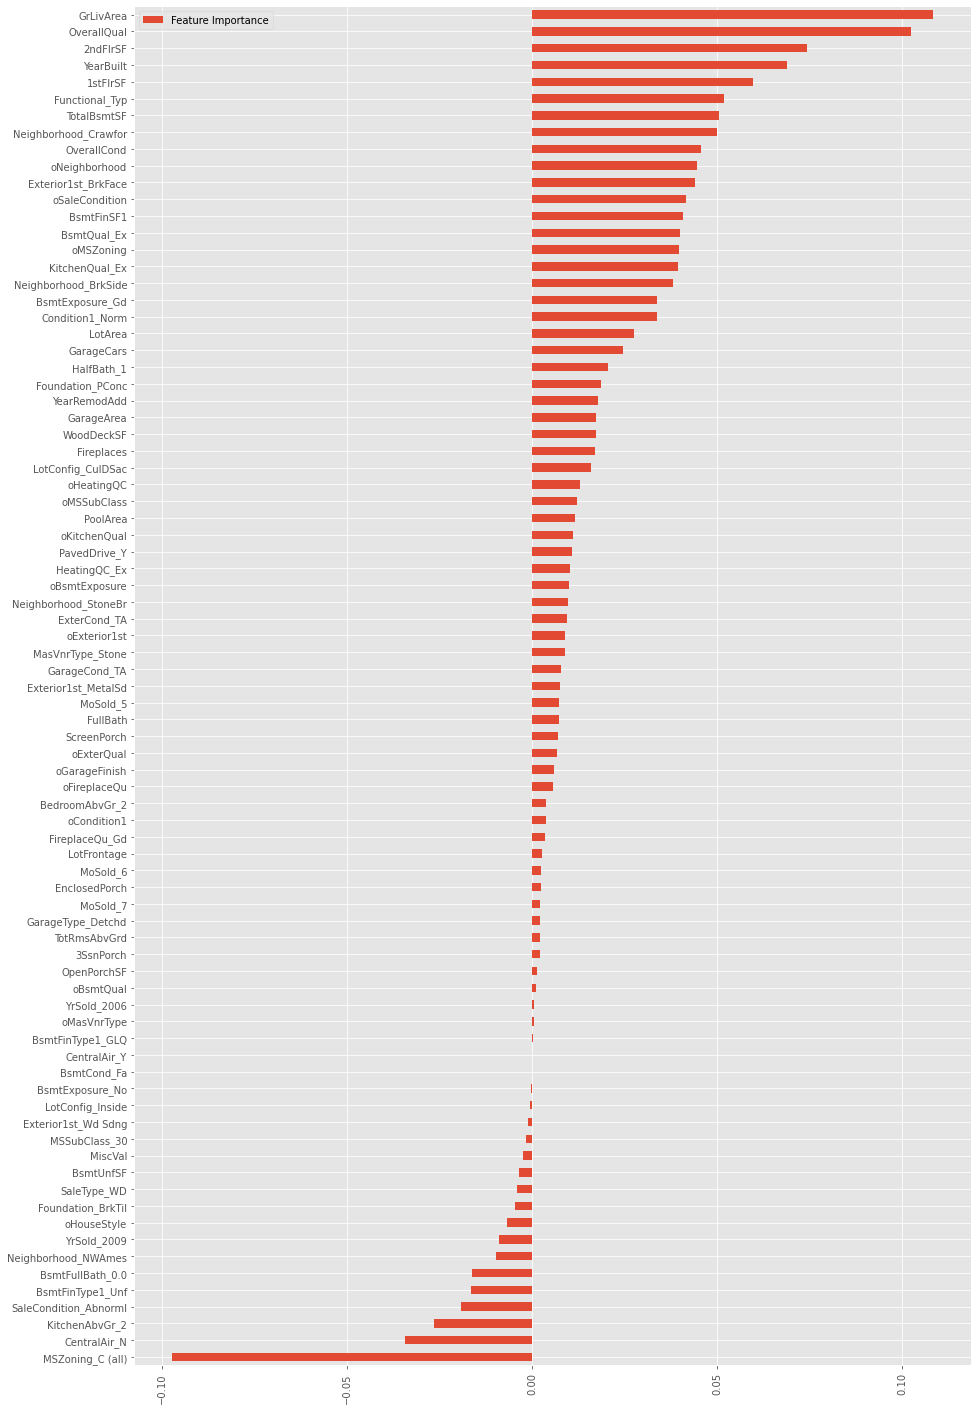

In [41]:

FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [42]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [43]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [44]:
full_pipe = pipe.fit_transform(full)
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)
pca = PCA(n_components=410)
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)
X_scaled.shape, test_X_scaled.shape


((1458, 410), (1459, 410))

In [45]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [46]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [47]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 2965221825.761285, 1533752568.7403
Ridge: 0.117521, 0.0091
Lasso: 0.121117, 0.0061
RF: 0.133016, 0.0069
GBR: 0.123942, 0.0076
SVR: 0.136836, 0.0123
LinSVR: 0.120895, 0.0092
Ela: 0.111394, 0.0060
SGD: 0.151637, 0.0141
Bay: 0.110557, 0.0060
Ker: nan, nan
Extra: 0.130708, 0.0052
Xgb: 0.137828, 0.0050


In [48]:

class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [49]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11157740804218777
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111688        0.001420
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111577        0.001371
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111875        0.001300
3  {'alpha': 0.0006, 'max_iter': 10000}         0.111674        0.001344
4  {'alpha': 0.0009, 'max_iter': 10000}         0.112260        0.001213
5  {'alpha': 0.0008, 'max_iter': 10000}         0.112090        0.001247


In [50]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})


{'alpha': 60} 0.11017620840430739
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110348        0.001272
1  {'alpha': 40}         0.110279        0.001254
2  {'alpha': 45}         0.110232        0.001239
3  {'alpha': 50}         0.110201        0.001227
4  {'alpha': 55}         0.110183        0.001217
5  {'alpha': 60}         0.110176        0.001209
6  {'alpha': 65}         0.110178        0.001202
7  {'alpha': 70}         0.110187        0.001196
8  {'alpha': 80}         0.110222        0.001188
9  {'alpha': 90}         0.110276        0.001182


In [51]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})


{'C': 14, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10811930056401522
                                                           params  mean_test_score  std_test_score
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, 'kernel': 'rbf'}         0.108617        0.001563
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'}         0.108262        0.001600
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'}         0.108566        0.001553
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'}         0.108227        0.001606
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, 'kernel': 'rbf'}         0.108597        0.001582
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'}         0.108223        0.001607
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'}         0.108513        0.001573
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'}         0.108166        0.001614
8   {'C': 13, 'epsilon': 0.

In [52]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.10816532791994835
                                                               params  mean_test_score  std_test_score
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'}         0.108165        0.001216
1     {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'}         0.108390        0.001253
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'}         0.108811        0.001300
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'}         0.108310        0.001193
4     {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'}         0.108177        0.001217
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'}         0.108394        0.001255
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'}         0.108682        0.001185
7     {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'}         0.108210    

In [53]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})


{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11138652131290996
                                                    params  mean_test_score  std_test_score
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter': 10000}         0.116550        0.002061
1    {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter': 10000}         0.116048        0.002038
2    {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter': 10000}         0.113153        0.001828
3    {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter': 10000}         0.112180        0.001621
4    {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter': 10000}         0.111818        0.001469
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter': 10000}         0.114761        0.001962
6    {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter': 10000}         0.114271        0.001920
7    {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter': 10000}         0.112133        0.001618
8    {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter': 10000}         0.111639        0.001411
9    {

In [54]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [55]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [56]:
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [57]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [58]:
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()


(array([0.10404348, 0.10939272, 0.11835014, 0.10005716, 0.10633811]),
 0.10763632048588508)

In [59]:
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()


(array([0.10248659, 0.10908177, 0.11756698, 0.09843509, 0.10536249]),
 0.10658658308277288)

In [60]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [62]:
a = SimpleImputer().fit_transform(X_scaled)
b = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)


print(rmse_cv(stack_model,a,b))
print(rmse_cv(stack_model,a,b).mean())

[0.10323543 0.10931792 0.11733868 0.09803461 0.10401005]
0.10638733723922929


In [63]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)
X_train_stack.shape, a.shape


((1458, 6), (1458, 410))

In [64]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))


In [65]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.09862121 0.10510207 0.11228985 0.09384413 0.09863799]
0.10169904960450912


In [66]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)


In [67]:
stack_model.fit(a,b)


stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
         mod=[Lasso(alpha=0.0005, max_iter=10000), Ridge(alpha=60),
              SVR(C=13, epsilon=0.009, gamma=0.0004),
              KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
              ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
              BayesianRidge()])

In [68]:
pred = np.exp(stack_model.predict(test_X_scaled))


In [69]:

result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)